# 00. 🔍 Intenção de Pesquisa

## Responder às seguintes questões

1. Existe relação entre as informações demográficas do indivíduo e a sua renda?
2. Existe correlação entre essas informações demográficas? Se sim, quais?

Para tanto, pretende-se usar métodos estatísticos para analisar as distribuições e avaliar a correlação dentro das variáveis categóricas e dentro das numéricas

# 01. 📑 Importações

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# 02. 📖 Lendo Dados

In [2]:
df = pd.read_csv('../data/01_raw/income.csv')
df.sample()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
24195,49,Federal-gov,94754,Masters,14,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K


# 03. 🧮 Dividindo em Treino e Teste e Analisando

In [3]:
y_col = ['income']
X_col = [col for col in df.columns if col not in y_col]

X = df[X_col]
y = df[y_col]

In [4]:
y['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [5]:
# convertendo rótulos em binário

y['income'] = y['income'].apply(lambda x: 1 if x == '>50K' else 0)
y['income'].unique()

array([0, 1])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=777)

In [7]:
y_train['income'].info()

<class 'pandas.core.series.Series'>
Index: 39073 entries, 41273 to 25002
Series name: income
Non-Null Count  Dtype
--------------  -----
39073 non-null  int64
dtypes: int64(1)
memory usage: 610.5 KB


In [8]:
positive_rate = int(y_train['income'].value_counts()[1] / len(y_train) * 100)
                    
print(f"taxa de positivos: {positive_rate}%")

taxa de positivos: 23%


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39073 entries, 41273 to 25002
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39073 non-null  int64 
 1   workclass        39073 non-null  object
 2   fnlwgt           39073 non-null  int64 
 3   education        39073 non-null  object
 4   educational-num  39073 non-null  int64 
 5   marital-status   39073 non-null  object
 6   occupation       39073 non-null  object
 7   relationship     39073 non-null  object
 8   race             39073 non-null  object
 9   gender           39073 non-null  object
 10  capital-gain     39073 non-null  int64 
 11  capital-loss     39073 non-null  int64 
 12  hours-per-week   39073 non-null  int64 
 13  native-country   39073 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.5+ MB


In [10]:
df['educational-num'] = df['educational-num'].astype('object') # correção de dtype

In [11]:
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

## 03.a 0️⃣ Análise de Valores Zerados

1. Existem muitos dados zerados nas colunas capital-gain capital-loss
2. Esses valores são realmente 0 ou são valores faltantes que foram preenchidos dessa forma?

In [12]:
X_train[num_cols].describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,39073.000000,3.907300e+04,39073.000000,39073.000000,39073.000000,39073.000000
mean,38.672075,1.895782e+05,10.087426,1063.749546,86.807028,40.441046
std,13.684519,1.060363e+05,2.568818,7376.302322,401.820249,12.417632
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175280e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779370e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376460e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


<Axes: >

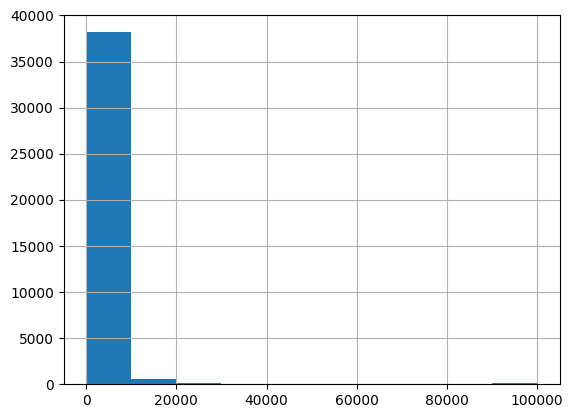

In [13]:
X_train['capital-gain'].hist()

<Axes: >

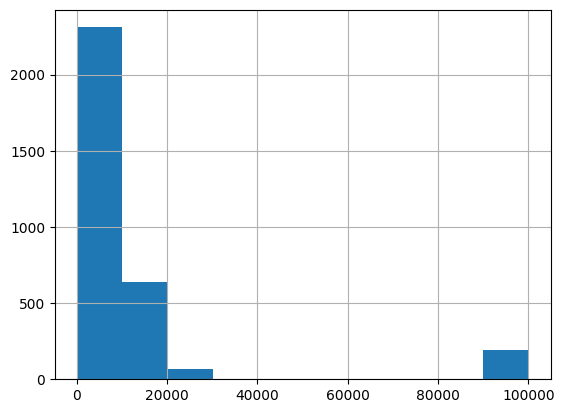

In [14]:
X_train[X_train['capital-gain'] != 0]['capital-gain'].hist()

<Axes: >

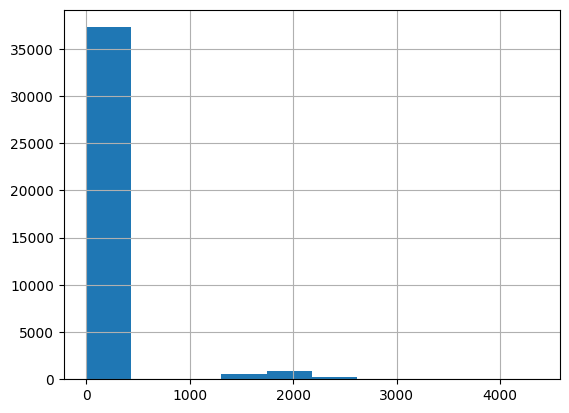

In [15]:
X_train['capital-loss'].hist()

<Axes: >

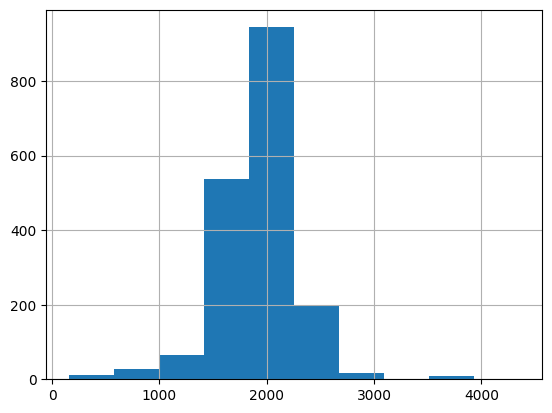

In [16]:
X_train[X_train['capital-loss'] != 0]['capital-loss'].hist()

In [17]:
print(len(X_train[X_train['capital-gain'] == 0]))
print(len(X_train[X_train['capital-gain'] != 0]))

X_train['no-capital-gain'] = X_train['capital-gain'].apply(lambda x: 1 if x == 0 else 0)

X_train['no-capital-gain'] = X_train['no-capital-gain'].astype('object')

35863
3210


In [18]:
print(len(X_train[X_train['capital-loss'] == 0]))
print(len(X_train[X_train['capital-loss'] != 0]))

X_train['no-capital-loss'] = X_train['capital-loss'].apply(lambda x: 1 if x == 0 else 0)

X_train['no-capital-loss'] = X_train['no-capital-loss'].astype('object')

37261
1812


In [19]:
cat_cols = X_train.select_dtypes(exclude='number').columns

### Teste Estatístico de Diferença Condicional

Como se tratam de colunas de ganho e perda de capital, vamos escolher colunas para comparar essas distribuições dentro dos dois grupos ("0" e "não 0"), para tanto, vamos escolher colunas que também possuem relação com poder financeiro.

As coluna escolhidas foram: workclass e occupation

O teste escolhido foi: o qui-2, pelo tamanho da amostra

alpha = 0.01

Ho: As variáveis são independentes

### Conclusão

Os zeros não são perdas aleatórias e que foram substituídas por 0. Pois os testes mostraram que há dependència entre eses valores e os das outras colunas

**workclass**

In [20]:
alpha = .01

tab = pd.crosstab(X_train['workclass'], X_train['no-capital-gain'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [21]:
print(p)

9.269749725222258e-49


In [22]:
alpha = .01

tab = pd.crosstab(X_train['workclass'], X_train['no-capital-loss'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [23]:
print(p)

8.613956305872887e-11


**occupation**

In [24]:
alpha = .01

tab = pd.crosstab(X_train['occupation'], X_train['no-capital-gain'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [25]:
alpha = .01

tab = pd.crosstab(X_train['occupation'], X_train['no-capital-loss'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


## 03.b ❓ Análise de "?"

Percebi que algumas colunas categóricas possuem valores "?" (native-country, workclass e occupation). O intuito é averiguar se são valores faltantes aleatórios ou se eles se relacionam com as demais features.

In [26]:
X_train[cat_cols].describe()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,no-capital-gain,no-capital-loss
count,39073,39073,39073,39073,39073,39073,39073,39073,39073,39073
unique,9,16,7,15,6,5,2,42,2,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,1,1
freq,27141,12667,17981,4932,15858,33422,26208,35040,35863,37261


In [27]:
X_train['native-country'].value_counts()[:10]

native-country
United-States    35040
Mexico             743
?                  709
Philippines        246
Germany            167
Puerto-Rico        152
Canada             150
India              122
El-Salvador        112
Cuba               110
Name: count, dtype: int64

In [28]:
X_train['workclass'].value_counts()

workclass
Private             27141
Self-emp-not-inc     3092
Local-gov            2510
?                    2236
State-gov            1554
Self-emp-inc         1383
Federal-gov          1129
Without-pay            21
Never-worked            7
Name: count, dtype: int64

In [29]:
X_train['occupation'].value_counts()

occupation
Prof-specialty       4932
Exec-managerial      4905
Craft-repair         4881
Sales                4436
Adm-clerical         4431
Other-service        3951
Machine-op-inspct    2410
?                    2243
Transport-moving     1894
Handlers-cleaners    1632
Farming-fishing      1187
Tech-support         1184
Protective-serv       787
Priv-house-serv       189
Armed-Forces           11
Name: count, dtype: int64

In [30]:
X_train['educational-num'].value_counts()

educational-num
9     12667
10     8620
13     6430
14     2114
11     1662
7      1437
12     1324
6      1104
4       780
15      684
5       590
8       530
16      482
3       391
2       191
1        67
Name: count, dtype: int64

In [31]:
def contains_unknown_value(row):
    total = 0
    for v in row:
        if v == '?':
            total += 1
    return total

X_train['unknown-value'] = X_train.apply(contains_unknown_value, axis=1)

In [32]:
X_train['unknown-value'].value_counts()

unknown-value
0    36163
2     2194
1      674
3       42
Name: count, dtype: int64

### Teste Estatístico de Diferença Condicional

Vamos escolher colunas para comparar essas distribuições dentro dos dois grupos ("?" e "não ?"), para tanto, optei por escolher as mesmas colunas usadas anteriormente (ganho e perda de capital)
As coluna escolhidas foram: workclass e occupation

O teste escolhido foi: o qui-2, pelo tamanho da amostra

alpha = 0.01

Ho: As variáveis são independentes

### Conclusão

Os "?" não são perdas aleatórias e que foram substituídas por ?. Pois os testes mostraram que há dependència entre eses valores e os da coluna de ganho de capital. Apesar de não termos evidência o bastante de para rejeitar a Ho no caso da coluna "perda de capital"

In [33]:
alpha = .01

tab = pd.crosstab(X_train['no-capital-gain'], X_train['unknown-value'])

ch2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [34]:
print(p)

0.005000769476708098


In [35]:
alpha = .01

tab = pd.crosstab(X_train['no-capital-loss'], X_train['unknown-value'])

ch2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

não temos evidencia o bastante para rejeitar Ho


In [36]:
print(p)

0.050184289041203964


## 03.c ↔️ Análise de Correlação de Features

### Numéricas

Primeiro vamos averiguar se as variáveis podem ser usadas na corr de pearson, isto é, se satisfazem os seguintes critérios:

1. possuem uma contagem grande o bastante
2. não são muito assimétricas (muitos valores zerados por exemplo)

Aqui temos que as variáveis "age" e "hours-per-week" passam nos critérios.
Contudo, as variáveis contínuas "capital-gain" e "capital-loss" não, por isso vamos ignorar seus valores

*conclusão*: não existe grande correlação entre as variáveis numéricas

<Axes: >

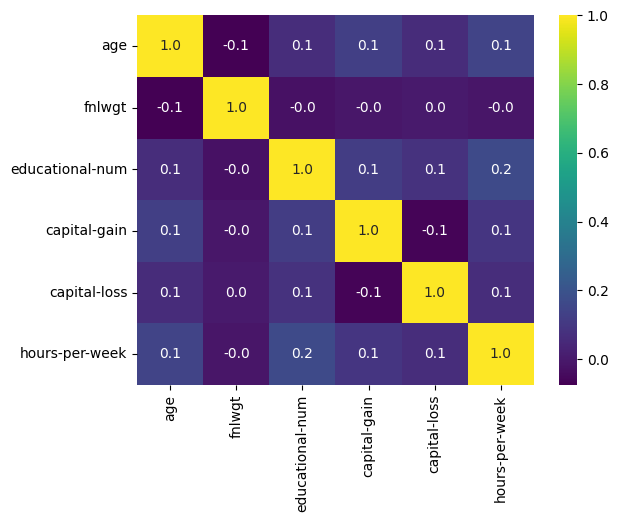

In [37]:
corr = X_train[num_cols].corr('spearman')

sns.heatmap(corr, annot=True, fmt='.1f', cmap='viridis')

### Categóricas

Vamos analisar a correlação usando um tipo de normalização do chi2 chamado v_cramer.

*conclusões:*

1. education e educational-num são equivalentes
2. existe grande correlação entre relationship, gender, marital status e occupation (acredito que muito em função das associações homem~marido e mulher~esposa)

Dado que gender possui considerável correlação entre genero e outras colunas, optou-se por manter as demais, pois elas já compreendem informação de gender e agregam outras.

Além disso, optou-se por remover a redundância de education

In [38]:
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.values.sum()
    r, c = table.shape
    return np.sqrt(chi2 / (n * (min(r, c) - 1)))

In [39]:
cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])

<Axes: >

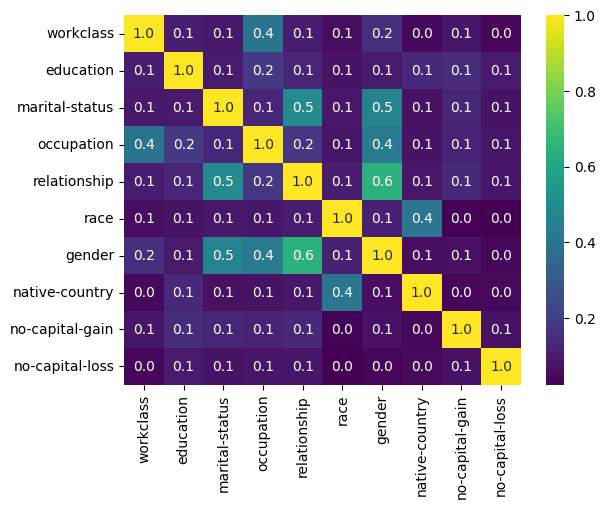

In [40]:
sns.heatmap(cramer_matrix, annot=True, fmt='.1f', cmap='viridis')

In [41]:
drop_cols = ['gender', 'education-num', 'no-capital-gain', 'no-capital-loss']

# 04. 🧪 Modelagem

## 04.a Naive Bayes

In [42]:
cat_cols = [col for col in cat_cols if not col in drop_cols]

In [43]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

ct = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', num_pipe, num_cols)
    ],
    remainder='drop'
)

pipe = Pipeline(steps=[
    ('ct', ct),
    ('nb', BernoulliNB())
])

param_grid = {
    'nb__alpha': [1e-3, 1e-2, 1e-1, 0.5, 1, 2, 5, 10],
    'nb__fit_prior': [True, False],
    
}

nb = GridSearchCV(pipe, param_grid, cv=10, scoring='f1')

nb.fit(X_train, y_train)

print(nb.best_score_)
print(nb.best_estimator_)
print(nb.best_params_)

0.6529170936197177
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('num',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='igno

## 04.b Logistic Regression

In [44]:
ct = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('ss', StandardScaler(), num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('lreg', LogisticRegression())
])

param_grid = [
    {
        "lreg__solver": ["lbfgs"],
        "lreg__penalty": ["l2"],
        "lreg__C": [0.1, 1, 5, 10, 20, 50]
    },
    {
        "lreg__solver": ["liblinear"],
        "lreg__penalty": ["l1", "l2"],
        "lreg__C": [0.1, 1, 5, 10, 20, 50]
    },
    {
        "lreg__solver": ["saga"],
        "lreg__penalty": ["elasticnet"],
        "lreg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "lreg__C": [0.1, 1, 5, 10, 20, 50]
    }
]

lreg = GridSearchCV(pipe, param_grid, cv=10, scoring='f1')

lreg.fit(X_train, y_train)

print(lreg.best_score_)
print(lreg.best_estimator_)
print(lreg.best_params_)

0.6591583681142932
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('lreg', LogisticRegression(C=50, solver='liblinear'))])
{'lreg__C': 50, 'lreg__penalty': 'l2', 'lreg__solver': 'liblinear'}


## 04.c CatBoost

In [45]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('num_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_pipe', num_pipe, num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('cb', CatBoostClassifier())
])

param_grid = {
    'cb__logging_level': ['Silent'],
    "cb__iterations": [500, 800],
    "cb__depth": [6, 8],
    "cb__learning_rate": [0.05, 0.1],
    "cb__l2_leaf_reg": [3, 5],
    "cb__subsample": [0.8, 1.0],
    "cb__loss_function": ["Logloss"],
    "cb__eval_metric": ["F1"],
    "cb__auto_class_weights": ["Balanced"],
}

cb = GridSearchCV(pipe, param_grid, cv=10, scoring='f1')

cb.fit(X_train, y_train)

print(cb.best_score_)
print(cb.best_params_)
print(cb.best_estimator_)

0.6636352751260762
{'cb__auto_class_weights': 'Balanced', 'cb__depth': 8, 'cb__eval_metric': 'F1', 'cb__iterations': 800, 'cb__l2_leaf_reg': 5, 'cb__learning_rate': 0.05, 'cb__logging_level': 'Silent', 'cb__loss_function': 'Logloss', 'cb__subsample': 1.0}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('bin',
                                                  

## 04.d Decision Tree

In [46]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('num_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_pipe', num_pipe, num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('dt', DecisionTreeClassifier())
])

param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [3, 5, 10, 12, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 5, 10],
    'dt__max_features': ['sqrt', 'log2'],
}

dt = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring='f1')

dt.fit(X_train, y_train)

print(dt.best_score_)
print(dt.best_params_)
print(dt.best_estimator_)

0.5875666022888766
{'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                    

## 04.e Random Forest

In [47]:
ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_ss', StandardScaler(), num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('rf', RandomForestClassifier())
])

param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [3, 7, 12],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': ['sqrt'],
}

rf = GridSearchCV(pipe, param_grid, cv=10, scoring='f1')

rf.fit(X_train, y_train)

print(rf.best_score_)
print(rf.best_params_)
print(rf.best_estimator_)

0.6499748536953922
{'rf__criterion': 'gini', 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('num_ss', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('rf',
                 

## 04.f SVM

In [48]:
ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_ss', StandardScaler(), num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('svc', SVC())
])

param_grid = {
    "svc__kernel": ["rbf"],
    "svc__C": [1, 5, 10],
    "svc__gamma": ["scale", 0.05, 0.1],
    "svc__class_weight": ["balanced"],
    "svc__probability": [True]
}

svc = GridSearchCV(pipe, param_grid, cv=10, scoring='f1')

svc.fit(X_train, y_train)

print(svc.best_score_)
print(svc.best_params_)
print(svc.best_estimator_)

0.683787381011974
{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__probability': True}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('num_ss', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('svc',
                 SVC(C=1, clas

# 05. 🎯 Avaliação do Modelo Escolhido

*Escolhido:* Regressão Logística
*Motivos:" critério objetivo é a maior taxa de acerto dentro da medida escolhida. Porém, a diferença é pouco significativa, logo o critério para cravar a decisão foi a intepretabilidade do modelo.

In [49]:
y_score_nb = rf.predict_proba(X_test)[:, 1]
y_score_lreg = lreg.predict_proba(X_test)[:, 1]
y_score_cb = cb.predict_proba(X_test)[:, 1]
y_score_dt = dt.predict_proba(X_test)[:, 1]
y_score_rf = rf.predict_proba(X_test)[:, 1]
y_score_svc = svc.predict_proba(X_test)[:, 1]

In [57]:
pr_nb, rec_nb, _ = precision_recall_curve(y_test, y_score_svc)
pr_lreg, rec_lreg, _ = precision_recall_curve(y_test, y_score_lreg)
# fpr_cb, tpr_cb, _ = precision_recall_curve(y_test, y_score_cb)

auc1 = auc(rec_nb, pr_nb)
auc2 = auc(rec_lreg, pr_lreg)
# auc3 = auc(fpr_cb, tpr_cb)

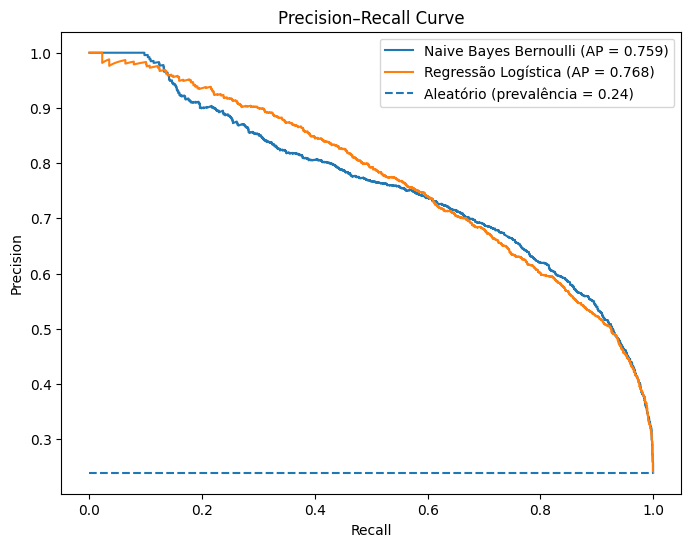

In [58]:
plt.figure(figsize=(8, 6))

plt.plot(rec_nb, pr_nb, label=f'Naive Bayes Bernoulli (AP = {auc1:.3f})')
plt.plot(rec_lreg, pr_lreg, label=f'Regressão Logística (AP = {auc2:.3f})')

baseline = y_test.mean()
plt.hlines(
    y=baseline,
    xmin=0,
    xmax=1,
    linestyles='--',
    label=f'Aleatório (prevalência = {baseline[0]:.2f})'
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


In [60]:
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      7431
           1       0.57      0.86      0.69      2338

    accuracy                           0.81      9769
   macro avg       0.76      0.83      0.78      9769
weighted avg       0.86      0.81      0.82      9769



In [61]:
y_pred = lreg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7431
           1       0.74      0.60      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.78      9769
weighted avg       0.85      0.85      0.85      9769



In [53]:
coefs = lreg.best_estimator_.named_steps['lreg'].coef_[0]


In [54]:
features_names = lreg.best_estimator_.named_steps['ct'].get_feature_names_out()

In [55]:
coef_df = pd.DataFrame({
    'feature': features_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values('abs_coef', ascending=False)

In [56]:
coef_df.head(20)

,feature,coef,abs_coef
79,ohe__native-country_Outlying-US(Guam-USVI-etc),-3.040306,3.040306
23,ohe__marital-status_Married-AF-spouse,2.643879,2.643879
24,ohe__marital-status_Married-civ-spouse,2.618845,2.618845
96,ss__capital-gain,2.395449,2.395449
37,ohe__occupation_Priv-house-serv,-2.345093,2.345093
76,ohe__native-country_Laos,-2.081521,2.081521
55,ohe__native-country_Columbia,-1.977080,1.977080
30,ohe__occupation_Armed-Forces,1.536532,1.536532
72,ohe__native-country_Ireland,1.516980,1.516980
91,ohe__native-country_Vietnam,-1.432895,1.432895


# 06. 💡 Conclusões

### Features que influênciam para ser a classe positiva (>50k):

1. capital_gain
2. O estado civil ser "Married-civ-spouse" ou "Married-AF-spouse"
3. não ter perda de capital registrada
4. ser dos países "Ireland", "Yugoslavia", "France"
5. ser da classe de trabalho "Federal-gov" (servidor público??)

*conclusão:* Parece que pessoas casadas e/ou imigrantes de países europeus e/ou servidores públicos tendem a ter uma renda superior (não necessariamente uma causalidade)

###  Features que influênciam para ser a classe negativa (<50k):

1. trabalhar com "Priv-house-serv" ou "Farming-fishing"
2. ser dos países "Columbia", "Laos", "Vietnam" ou "Mexico"
3. estado civil como "Other-relative"

*conclusão:* Aparentemente imigrantes da América Latina, Leste Asiático e/ou com trabalho rural e/ou estado civil como "outro" tendem a ter renda inferior (não necessariamente uma causalidade)

### Sugestão de próximo estudo e limitações

Aparentemente as features de ganho e perda de capital têm muita importância, pode fazer sentido conduzir um estudo sem levar elas em conta e averiguar o poder preditivo do modelo com as demais.